In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
from functions import *
from constants import *
from datetime import datetime
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')


# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=7)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


RESULTADOS PRIMEER CONSULTA:


,FECHA_EJECUCION,TEST,MODEL,FORECAST_TO_DO,MONTHS_TO_FORECAST,MONTHS_TO_TEST,FROM_YEAR,TOTAL_MODELOS,MAPE_DEACERO,P15,P50,P85,MIN_MAPE_DEACERO,MAX_MAPE_DEACERO,NUMERO_COMBINACIONES
0,2025-09-19 23:40:05,0,Todos los modelos,ToneladasFacturadas,10,6,2022,8,82.212258,11.5,28.9688,75.4751,0.0,64577.213,527


PARAMETROS DE EJECUCION:
2022 6 10
date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-04-01


## Generamos Resultados Modelo MIDAS V1

In [2]:
ls "../../bd/Facturacion BQ/MIDAS"

 El volumen de la unidad C es Windows 
 El n�mero de serie del volumen es: FC47-8A0A

 Directorio de c:\Users\adojeda\OneDrive - deacero.com\bd\Facturacion BQ\MIDAS

22/09/2025  09:02 a. m.    <DIR>          .
09/09/2025  09:16 a. m.    <DIR>          ..
11/09/2025  09:07 a. m.    <DIR>          20250717
11/09/2025  09:10 a. m.    <DIR>          20250909
17/09/2025  11:12 a. m.    <DIR>          20250917
18/09/2025  06:14 p. m.    <DIR>          20250918
22/09/2025  09:03 a. m.    <DIR>          20250919_5M
10/09/2025  08:06 a. m.    <DIR>          PRONOSTICO 2025
               0 archivos              0 bytes
               8 dirs  319,519,268,864 bytes libres


In [3]:
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/20250919_5M"

list_df = []
for num, path in  enumerate(os.listdir(LIST_DIR)):
    print(num, path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df
base = pd.concat(list_df)
del list_df

base_t = transform_MIDAS(base)

base_t['WOC_v1'] = base_t[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)
base_t.sample(5)

0 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_024701.csv
1 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_053308.csv
2 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_044653.csv
3 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_032735.csv
4 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_001549.csv
5 outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_040643.csv
6 outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_020826.csv
7 outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250920_012950.csv


,MesAnio,NombreSubdireccion,NombreGrupoEstadistico3,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
5627,2025-07-01,MAYORISTAS ACEROS,CICLONICA GALVANIZADA,7.370386,15.264747,23.121414,24.654013,17.613740,7.497738,12.618103,18.909559,1.043,15.881212
803,2024-10-01,INDUSTRIAS,ALAMBRE RECOCIDO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.067,0.000000
4358,2025-05-01,CENTRO SUR,VARILLA 6000,42.471259,29.459563,42.043017,46.441625,31.970064,41.734220,37.838033,24.045647,36.808,37.000428
2560,2025-01-01,PERFILES NACIONAL,ALAMBRON TREFILAR MYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.760,0.000000
9855,2026-03-01,MAYORISTAS ACEROS,MALLA MOSQUITERA,0.831900,0.853300,0.996700,1.066800,0.834800,0.860000,0.808900,0.883000,NaN,0.891925


In [4]:
base_t.groupby("MesAnio").sum(numeric_only = True).round(0)

,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
MesAnio,,,,,,,,,,
2024-09-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190736.0,0.000000e+00
2024-10-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200258.0,0.000000e+00
2024-11-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203769.0,0.000000e+00
2024-12-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173655.0,0.000000e+00
2025-01-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226006.0,0.000000e+00
2025-02-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206657.0,0.000000e+00
2025-03-01,6.593198e+16,208678.0,209455.0,202156.0,208158.0,208352.0,204008.0,208288.0,212932.0,8.241498e+15
2025-04-01,1.463079e+23,203579.0,203942.0,210852.0,203620.0,201865.0,208882.0,206652.0,204263.0,1.828848e+22
2025-05-01,5.451946e+25,200820.0,200932.0,204349.0,200363.0,201444.0,205278.0,208092.0,205227.0,6.814933e+24


## GENERAMOS HISTORICOS DE PV, PVO Y FACTURACION DESDE BQ

In [6]:
FACT = load_fact_pvo_pv()
FACT = add_zeros(FACT, date_today)
FACT.sample(5)

Consultando PV
Consultando PVO
Consultando FACT
2782
2782
2782
(79963, 11)
0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 NombreGrupoEstadistico1
4 NombreGrupoEstadistico2
5 NombreGrupoEstadistico3
2093


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2
42094,2025-09-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,FERRETEROS,MULTIMALLA FERRETERA,1.80761,1.80761,1.65100,5.26622,0.837333,1.372972,ALMACEN ANSA_MULTIMALLA FERRETERA
71395,2025-10-01,FILIALES ALAMBRES_TURIA_TURIA_VARILLA_VARILLA ...,FILIALES ALAMBRES,TURIA,TURIA,VARILLA,VARILLA,VARILLA 1 1/4,293.00017,293.00000,0.00000,586.00017,476.142000,318.149722,TURIA_VARILLA 1 1/4
2247,2025-12-01,ACEROS_ACEROS MEXICO_MAYORISTAS ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,MAYORISTAS ACEROS,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,ALAMBRE DE PÚAS PVC,NaN,NaN,0.00000,0.00000,0.000000,0.0,MAYORISTAS ACEROS_ALAMBRE DE PÚAS PVC
10388,2025-03-01,ACEROS_ACEROS MEXICO_PERFILES NACIONAL_PERFILE...,ACEROS,ACEROS MEXICO,PERFILES NACIONAL,PERFILES,PERFILES COMERCIALES,ANGULOS COMERCIALES,2238.10769,2290.73012,2951.72200,7480.55981,2294.325253,2672.898812,PERFILES NACIONAL_ANGULOS COMERCIALES
79991,2025-06-01,TRASPASOS E INTEREMPRESAS_EXPORTACION FILIALES...,TRASPASOS E INTEREMPRESAS,EXPORTACION FILIALES,FILIALES,PERFILES,VIGAS IPR,VIGAS IPR,1959.06192,2120.89000,2077.50529,6157.45721,1898.282333,1488.427768,FILIALES_VIGAS IPR


In [7]:
FACT.groupby("MesAnio")[["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]].sum().round(0)

,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,,
2025-01-01,319541.0,309265.0,328487.0
2025-02-01,323747.0,330500.0,301610.0
2025-03-01,314116.0,311392.0,298606.0
2025-04-01,297967.0,299818.0,276743.0
2025-05-01,349645.0,351032.0,286634.0
2025-06-01,354625.0,349853.0,269711.0
2025-07-01,320277.0,318095.0,285686.0
2025-08-01,317260.0,311227.0,316013.0
2025-09-01,347612.0,362910.0,177123.0


# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

### Consulta RESULTADOS MODELO MIDAS_V2

In [ ]:
forecast = data_bq(QUERY_RESULTADOS_MODEL2)
print("CONSULTANDO RESULTADOS MODELO 2")
forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)
forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)
forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)
forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

#print(forecast.FECHA.value_counts().sort_index().tail(10))

out = transform_MIDAS(forecast)
print("TRANSFORMANDO DATOS")

out.MesAnio = pd.to_datetime(out.MesAnio)

display(out.groupby("MesAnio").sum(numeric_only = True).round(0))

out = out.merge(base_t, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1", suffixes=('', '_v1'))

out["MAX_MODEL"] = True
# FACT LIMITA LOS RESULTADOS......
out = FACT.merge(out, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out.sample(5)

CONSULTANDO RESULTADOS MODELO 2
FECHA
2025-09-01    4216
2025-10-01    4216
2025-11-01    4216
2025-12-01    4216
2026-01-01    4216
2026-02-01    4216
2026-03-01    4216
2026-04-01    4216
2026-05-01    4216
2026-06-01    4216
Name: count, dtype: int64
TRANSFORMANDO DATOS


,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2
MesAnio,,,,,,,,,
2024-09-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190736.0
2024-10-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200258.0
2024-11-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203769.0
2024-12-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173655.0
2025-01-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226006.0
2025-02-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206657.0
2025-03-01,6.593198e+16,208678.0,209455.0,202156.0,208158.0,208352.0,204008.0,208288.0,212932.0
2025-04-01,1.463079e+23,203579.0,203942.0,210852.0,203620.0,201865.0,208882.0,206652.0,204263.0
2025-05-01,5.451946e+25,200820.0,200932.0,204349.0,200363.0,201444.0,205278.0,208092.0,205227.0


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL
12357,2025-10-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_PERFILES_RE...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,PERFILES,REDONDOS Y CUADRADOS,REDONDOS COMERCIALES,NaN,NaN,0.0,0.00000,0.000000,0.0,ALMACEN ANSA_REDONDOS COMERCIALES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
27438,2026-01-01,USA_EUA - CANADA_INDUSTRIAL WIRE_MALLAS Y ALAM...,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,FASTENERS MCSW,PLASTIC STRIP,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAL WIRE_PLASTIC STRIP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
18631,2025-12-01,FILIALES ALAMBRES_INDASA_INDASA_MALLAS Y ALAMB...,FILIALES ALAMBRES,INDASA,INDASA,MALLAS Y ALAMBRES,NEGROS ANTAAC,CASTILLO HOJAS,273.99999,273.99999,0.0,547.99998,953.013283,142.167529,INDASA_CASTILLO HOJAS,178.1612,166.7419,182.2595,209.6833,176.1523,178.1183,709.0753,167.003098,NaN,178.1612,166.7419,182.2595,209.6833,176.1523,178.1183,709.0753,167.003098,NaN,245.899362,True
8706,2026-01-01,ALAMBRES_ALAMBRES_NORTE_MALLAS Y ALAMBRES_FERR...,ALAMBRES,ALAMBRES,NORTE,MALLAS Y ALAMBRES,FERRETEROS,HEXAGONAL NETTING,14.00000,13.42575,0.0,27.42575,11.937667,11.404327,NORTE_HEXAGONAL NETTING,10.3373,10.2832,10.2835,8.1337,10.4011,10.3474,10.1837,10.316800,NaN,10.3373,10.2832,10.2835,8.1337,10.4011,10.3474,10.1837,10.316800,NaN,10.035838,True
25425,2025-02-01,USA_EUA - CANADA_AGRICULTURAL DISTRIBUTION_PER...,USA,EUA - CANADA,AGRICULTURAL DISTRIBUTION,PERFILES,PERFILES ESTRUCTURALES,CANALES ESTRUCTURALES,NaN,NaN,NaN,0.00000,0.000000,0.0,AGRICULTURAL DISTRIBUTION_CANALES ESTRUCTURALES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### PROCESO POP

In [9]:
df = out.copy()

#FILTRO LIMITE INFERIOR
df = df [df.MesAnio >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.MesAnio <= date_forecas]

df['Segmento'] = np.where ((df.MesAnio >= date_last_6m) & (df.MesAnio < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
#df['WOC'] = df.mean(numeric_only = True, axis = 1)
df['WOC'] = df[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)

df['WOC_v1'] = df[['BayesianRidge_v1', 'GradientBoostingRegressor_v1', 'KNeighborsRegressor_v1','LGBMRegressor_v1', 'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1','XGBRegressor_v1']].fillna(0).mean(axis = 1)

df.groupby("MesAnio").Segmento.last()

MesAnio
2025-03-01    Validacion
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Validacion
2025-09-01    Pronostico
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
2026-01-01    Pronostico
2026-02-01    Pronostico
Name: Segmento, dtype: object

In [10]:
display(df.isna().sum())

# imputamos 0s
df.fillna(0, inplace=True)

display(df.isna().sum())

df.tail()

MesAnio                             0
id                                  0
NombreGrupo                         0
NombreDireccion                     0
NombreSubdireccion                  0
NombreGrupoEstadistico1             0
NombreGrupoEstadistico2             0
NombreGrupoEstadistico3             0
toneladas_pvo                   13181
toneladas_plan_ventas           12417
toneladas_facturadas             5595
valid_ton                           0
TP_MESES                         2939
TP_MOVIL                         3181
id2                                 0
BayesianRidge                   18948
GradientBoostingRegressor       18948
KNeighborsRegressor             18948
LGBMRegressor                   18948
RandomForestRegressor           18948
Ridge                           18948
SVR                             18948
XGBRegressor                    18948
Y_HIST2                         22032
BayesianRidge_v1                18948
GradientBoostingRegressor_v1    18948
KNeighborsRe

MesAnio                         0
id                              0
NombreGrupo                     0
NombreDireccion                 0
NombreSubdireccion              0
NombreGrupoEstadistico1         0
NombreGrupoEstadistico2         0
NombreGrupoEstadistico3         0
toneladas_pvo                   0
toneladas_plan_ventas           0
toneladas_facturadas            0
valid_ton                       0
TP_MESES                        0
TP_MOVIL                        0
id2                             0
BayesianRidge                   0
GradientBoostingRegressor       0
KNeighborsRegressor             0
LGBMRegressor                   0
RandomForestRegressor           0
Ridge                           0
SVR                             0
XGBRegressor                    0
Y_HIST2                         0
BayesianRidge_v1                0
GradientBoostingRegressor_v1    0
KNeighborsRegressor_v1          0
LGBMRegressor_v1                0
RandomForestRegressor_v1        0
Ridge_v1      

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC
29297,2025-10-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,140.527333,3.912314,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29298,2025-11-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,6.804000,4.564366,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29299,2025-12-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,0.000000,3.964261,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29300,2026-01-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,21.96082,0.0,0.0,21.96082,27.168373,2.923987,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
29301,2026-02-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,19.75174,0.0,0.0,19.75174,0.000000,3.411319,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0


In [11]:
df.columns [df.dtypes == float]

Index(['toneladas_pvo', 'toneladas_plan_ventas', 'toneladas_facturadas',
       'valid_ton', 'TP_MESES', 'TP_MOVIL', 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor', 'Y_HIST2',
       'BayesianRidge_v1', 'GradientBoostingRegressor_v1',
       'KNeighborsRegressor_v1', 'LGBMRegressor_v1',
       'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1',
       'Y_HIST2_v1', 'WOC_v1', 'WOC'],
      dtype='object')

In [12]:
cols2mape = df.columns [df.dtypes == float].to_list()
cols2mape = [
                "toneladas_pvo", "toneladas_plan_ventas", 
                'BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor','WOC',
                'BayesianRidge_v1', 'GradientBoostingRegressor_v1','KNeighborsRegressor_v1', 'LGBMRegressor_v1','RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1', 'WOC_v1',
                "TP_MESES", "TP_MOVIL"
            ]
#cols2mape.remove("toneladas_facturadas")
#cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2): 
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.median() # podriamos cambiarla a median para evitar colas.....

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'toneladas_facturadas', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['id2', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('id2')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
toneladas_pvo
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL
calulamos avg_mape a grupo -----------------------
toneladas_pvo
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL


In [13]:
df = df.reset_index(drop = True)
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1)).apply(lambda x:x[9:])

anakin = df.melt('MAX_Modelo', ignore_index = False)

df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    try: 
        if df[col1] <= 0.1 and df[col2] <= 0.1:
            return 0
        elif df[col1] <= 0.1 and df[col2] > 0.1:
            return 1
        elif df[col1] > 0.1 and df[col2] <= 0.1:
            return 1
        else:
            return df[col1]/df[col2]
    except: np.nan

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'toneladas_pvo', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] == np.nan:
        return np.nan
    elif df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC,toneladas_pvo_MAPE,toneladas_plan_ventas_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,BayesianRidge_v1_MAPE,GradientBoostingRegressor_v1_MAPE,KNeighborsRegressor_v1_MAPE,LGBMRegressor_v1_MAPE,RandomForestRegressor_v1_MAPE,Ridge_v1_MAPE,SVR_v1_MAPE,XGBRegressor_v1_MAPE,WOC_v1_MAPE,TP_MESES_MAPE,TP_MOVIL_MAPE,AVG_MAPE_toneladas_pvo,AVG_MAPE_toneladas_plan_ventas,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,AVG_MAPE_BayesianRidge_v1,AVG_MAPE_GradientBoostingRegressor_v1,AVG_MAPE_KNeighborsRegressor_v1,AVG_MAPE_LGBMRegressor_v1,AVG_MAPE_RandomForestRegressor_v1,AVG_MAPE_Ridge_v1,AVG_MAPE_SVR_v1,AVG_MAPE_XGBRegressor_v1,AVG_MAPE_WOC_v1,AVG_MAPE_TP_MESES,AVG_MAPE_TP_MOVIL,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion
0,2025-03-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
1,2025-04-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
2,2025-05-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
3,2025-06-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
4,2025-07-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,V

In [14]:
df[df.MAX_MODEL == True].groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
BayesianRidge                   93
Ridge                           74
GradientBoostingRegressor       69
toneladas_pvo                   42
XGBRegressor                    32
LGBMRegressor                   25
RandomForestRegressor           24
KNeighborsRegressor             23
BayesianRidge_v1                21
Ridge_v1                        18
WOC                             17
SVR                             12
GradientBoostingRegressor_v1    12
XGBRegressor_v1                 10
TP_MESES                        10
KNeighborsRegressor_v1           7
RandomForestRegressor_v1         6
LGBMRegressor_v1                 5
TP_MOVIL                         4
toneladas_plan_ventas            4
WOC_v1                           3
SVR_v1                           3
Name: count, dtype: int64

In [ ]:
df.groupby("id2").MAX_Modelo.first().value_counts()

In [16]:
# GUARDAMOS RESULTADOS
from datetime import date
df.to_excel("Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [17]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]
valores = [df[col]  for col in cols2mape]
# Valores a imputar según condiciones
df['FCST'] = np.select(condiciones, valores, default=None)
df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["toneladas_facturadas"], df["FCST"])

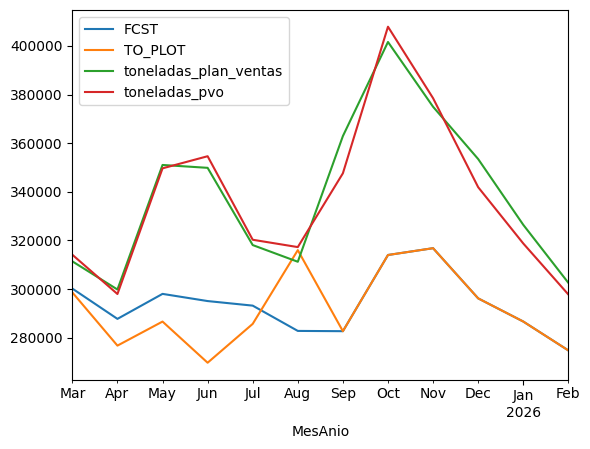

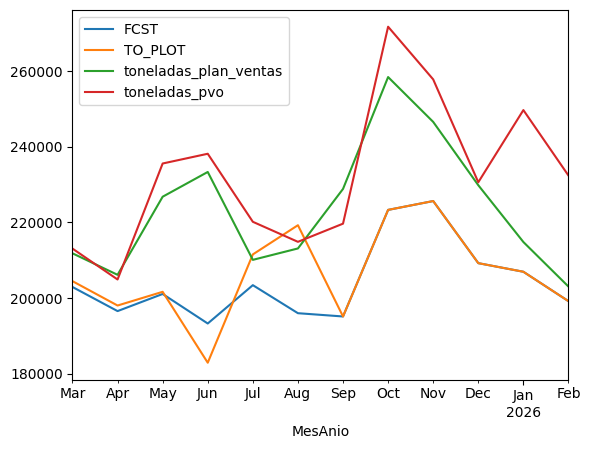

In [18]:
import matplotlib.pyplot as plt
df[  (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()
df[ (df.MAX_MODEL== True) & (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()

In [19]:
df[ (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"})

,FCST,TO_PLOT,toneladas_plan_ventas,toneladas_pvo
MesAnio,,,,
2025-03-01,300197.454818,298605.668502,311391.500170,314116.19172
2025-04-01,287740.427344,276743.213118,299817.871770,297967.42046
2025-05-01,298018.130762,286633.726366,351031.823050,349645.48651
2025-06-01,295067.224114,269710.692785,349852.504730,354624.92090
2025-07-01,293187.962168,285686.192685,318095.420100,320277.35154
2025-08-01,282788.132804,316013.062493,311227.383510,317260.29013
2025-09-01,282679.068467,282679.068467,362910.375110,347611.79835
2025-10-01,314010.297834,314010.297834,401604.156994,407880.33085
2025-11-01,316809.355623,316809.355623,374963.959027,378487.47063
